<h1 style="font-size:35px;
        color:black;
        ">Lab 3 Accuracy of Quantum Phase Estimation</h1>

[Lab 3 Accuracy of Quantum Phase Estimation](https://qiskit.org/textbook/ch-labs/Lab03_AccuracyQPE.html)  
シミュレータ部分だけを実装しました。

前提知識
- [Ch.3.5 Quantum Fourier Transform](https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html)
- [Ch.3.6 Quantum Phase Estimation](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html)

参考文献
- [QCQI] Michael A. Nielsen and Isaac L. Chuang. 2011. Quantum Computation and Quantum Information

# はじめに
ユニタリ演算子$U$の固有値$\phi$を量子位相推定(Quantum Phase Estimation:QPE)を用いて求めます。  
$U$の固有状態を$|\psi\rangle$とすると、
$$
U|\psi\rangle = e^{2\pi\phi}\psi\rangle
$$
と表すことが出来ます。ここで$0\le\phi<1$になります。  
具体的な回路の実装方法は[Ch.3.6 Quantum Phase Estimation](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html)を参照して下さい。  
実装時に$\phi$は有限個の計測用ビットを用いて2進数で展開されます。  
計測用の量子ビット数が$N$個の場合は、
$$
\phi = \sum^{N-1}_{i=0}\frac{q_i}{2^{N-i}}
$$
となります。  
回路図で表示した時に一番上の量子ビットを$q_0$、一番下の量子ビットを$q_{N-1}$とすると、Qiskit上でケット状態は$|q_{N-1}q_{N-2}\cdots q_1q_0\rangle$と表現できます。  
実際にはこの状態の各量子ビットの値($0, 1$)が測定されてその結果を元に、
$$
\bar{\phi} = \sum^{N-1}_{i=0}2^iq_i
$$
を計算してから全体を$2^N$で割ると$\phi$が求められます。  
3.5章で計算されている様に$\phi=\frac{1}{8}$であれば$\frac{1}{8} = \frac{1}{2^3}$なので綺麗に2進数展開できるため正確に答えを求めることが出来ます。  
例えば4量子ビットを計測用に使用すると$|0010\rangle$が答えとして出力されると計算が正しいことがわかります。  
$\bar{\phi} = 8*0+4*0+2*1+1*0=2$なので、$\phi=\frac{\bar{\phi}}{16}=\frac{1}{8}$が得られます。  
一方で$\phi=\frac{1}{3}$の様な中途半端な値の場合は綺麗に2進数展開ができないので必ず誤差が発生します。  

# 目的
この章では使用する量子ビット数と推定する値の精度との関係について調べます。  
特に真の値$\phi=\frac{1}{3}$に対して、使用する**計測用量子ビットの数$t$**と**精度$2^{-n}$**を変えながら、この精度の範囲内で正しい答えが得られる確率(成功確率)などを求めていきます。  
量子コンピュータで計算した結果を$m$とすると、
$$
|m-\frac{1}{3}| < \frac{1}{2^n}
$$
であれば$2^{-n}$の精度で正しい答えが得られたことになります。

## 回路のノーテーション
量子回路の上から$t$個の量子ビットは計測用の量子ビットとして使用します。  
$t+1$個目を$U$の固有状態を表す量子ビットに使用します。

# 1. t=4, n=2の場合
まずは計測用の量子ビットの数を$t=4$、精度を$2^{-2}$として計算を行います。  
QPEを行うための回路を実装していく。後のために$t, n$の値は固定せずにパラメータとして変更できる様に実装します。  

## モジュールのインポート

In [1]:
from qiskit import *
import numpy as np
from qiskit.visualization import plot_histogram
import qiskit.tools.jupyter
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.mitigation.measurement import *
import matplotlib.pyplot as plt
import math

## 位相の値
$\phi$の値は$\phi=\frac{1}{3}$で固定されています。  
`angle`に値を格納します。

In [2]:
phi = 1./3.
angle = 2*math.pi*phi

## 逆量子フーリエ変換
- 入力：circ(量子回路のインスタンス), n(逆QFTで使用する量子ビット数)
- 出力：circ(量子回路のインスタンス)

In [3]:
# Inverse Quantum Fourier Transformation
def qft_dagger(circ, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        circ.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            circ.cp(-math.pi/float(2**(j-m)), m, j)
        circ.h(j)

## 量子位相推定の回路
- 入力：t(計測用の量子ビット数)
- 出力：qc(量子回路のインスタンス)

In [4]:
# Quantum Phase Estimation Circuit
def make_QPE_circuit(t):
    qc = QuantumCircuit(t+1, t)
    qc.x(t)
    for q in range(t):
        qc.h(q)
    repetitions = 1
    for counting_qubit in range(t):
        for i in range(repetitions):
            qc.cp(angle, counting_qubit, t); # This is C-U
        repetitions *= 2
    qc.barrier()
    # Apply inverse QFT
    qft_dagger(qc, t)
    # Measurement
    qc.barrier()
    for q in range(t):
        qc.measure(q, q)
    return qc

## 計算の実行

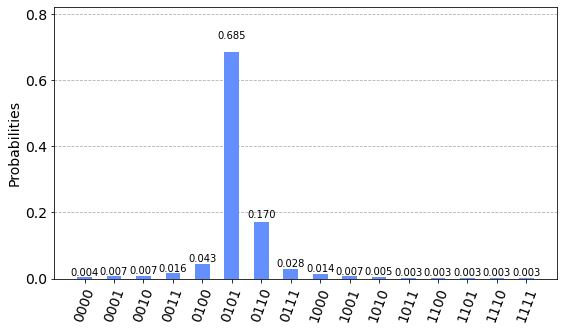

In [5]:
t = 4
qc4 = make_QPE_circuit(t)
sim = Aer.get_backend('qasm_simulator')
shots = 20000
count_qc4 = execute(qc4, sim, shots=shots).result().get_counts()
plot_histogram(count_qc4, figsize=(9,5))

結果を見ると`0101`の出力結果が一番高くなっています。  
この値を$\phi$に変換すると、$\bar{\phi}=4+1=5$なので、$\phi=\frac{5}{16}=0.3125$になります。  
真の値との誤差は

In [6]:
abs(0.3125-phi)

0.020833333333333315

In [7]:
abs(0.3125-phi) < 2**(-4)

True

4量子ビットを使っているので誤差は$\delta = 2^{-4} = 0.0625$に収まっている必要があります。  
`0101`は上の様に実際に$\delta$の範囲に収まっています。

## 結果の評価
この章で行われている解析に沿って評価を行っていきます。  
まずは得られた結果の中で真の値$\phi=\frac{1}{3}$に最も近い推定結果$b$を求めます。  
`count_qc4`に測定結果が格納されているのでこの中から測定数の最も多い結果を抽出します。

In [8]:
max_binary, max_mes = max(count_qc4.items(), key=lambda x: x[1])
b = int(max_binary, 2)/2**t
print(max_binary, max_mes)
print(b)

0101 13693
0.3125


真の値$\phi$から$2^{-2}$の範囲に収まっている結果を$\boldsymbol{m}$とします。  
$$
\phi-2^{-2} < m < \phi+2^{-2}
$$
この$\boldsymbol{m}$に対して、
$$
|m-b|\le \frac{e}{2^t}
$$
を満たす最大の整数$e$を求めます。  
これはビット表示で考えると$b$から最大で何ビット離れているのかを求めることになります。  
例えば$e=1$だと`0101`から1ビット離れている状態は`0100`,`0101`, `0110`になります。  
$\boldsymbol{m}$が全て上記の不等式の収まる様な$e$を求めにいきます。  
まずは$\boldsymbol{m}$を列挙して`m_list`に格納します。

In [9]:
n = 2
ac = 2**(-n)
m_list = []
for i in range(2**t):
    v = i/2**t
    if (b-ac < v < b+ac):
        print(i, format(i, '0{}b'.format(t)), v)
        m_list.append(i)

2 0010 0.125
3 0011 0.1875
4 0100 0.25
5 0101 0.3125
6 0110 0.375
7 0111 0.4375
8 1000 0.5


次に$|m-b|\le \frac{e}{2^t}$を満たす最大の$e$を求めます。

In [10]:
# Estimate e
e = 0
while(True):
    count = 0
    for i in m_list:
        m = i/2**t
        if (abs(m-b) <= e/2**t):
            count += 1
        else:
            break
    if (count == len(m_list)):
        break
    e += 1
print(e)

3


$e=3$であることが分かりました。

`[QCQI]`によると計測用量子ビットの数が$t$で要求精度が$2^{-n}$の結果が得られる確率は
$$
1- \frac{1}{2(2^{(t-n)}-2)}
$$
であるようです。  
これを満たしているか確認します。

In [11]:
m_list

[2, 3, 4, 5, 6, 7, 8]

In [12]:
bound = 1.0 - 1/(2*(2**(t-n)-2))
success_prob = (sum(count_qc4[format(m, '0{}b'.format(t))] for m in m_list))/shots
print(success_prob, bound)
print(success_prob >= bound)

0.96255 0.75
True


# 2. t=[4,5,6,7,8,9]の場合

計測用量子ビットの数$t$を変更した時の成功確率を理論値と計測値を比較しながら計算していきます。  
成功確率は
$$
1- \frac{1}{2(2^{(t-n)}-2)}
$$
と表せます。  
$t$を4から9まで変化させた時の理論値をプロットすると以下のように表せます。

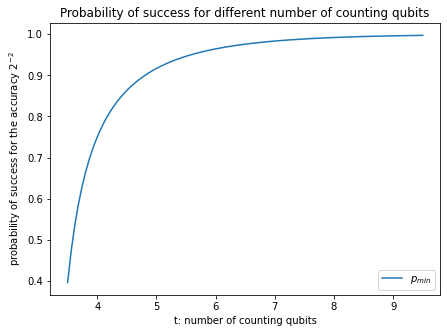

In [13]:
y_prob = lambda t, n: 1-1/(2*(2**(t-n)-2))
t_q = np.linspace(3.5, 9.5, 100 )
p_min = y_prob(t_q, 2)

plt.figure(figsize=(7, 5))
plt.plot(t_q, p_min, label='$p_{min}$')
plt.xlabel('t: number of counting qubits')
plt.ylabel('probability of success for the accuracy $2^{-2}$')
plt.legend(loc='lower right')
plt.title('Probability of success for different number of counting qubits')
plt.show()

これを先ほどと同様に量子回路を作成し計測して比較を行います。  
`make_QPE_circuit`の入力値$t$を4から9に変化させて量子回路を作成し`circ`に格納します。  
`circ`に格納された量子回路を用いて計測を一気に行います。

In [14]:
circ = [make_QPE_circuit(t) for t in range(4, 10)]

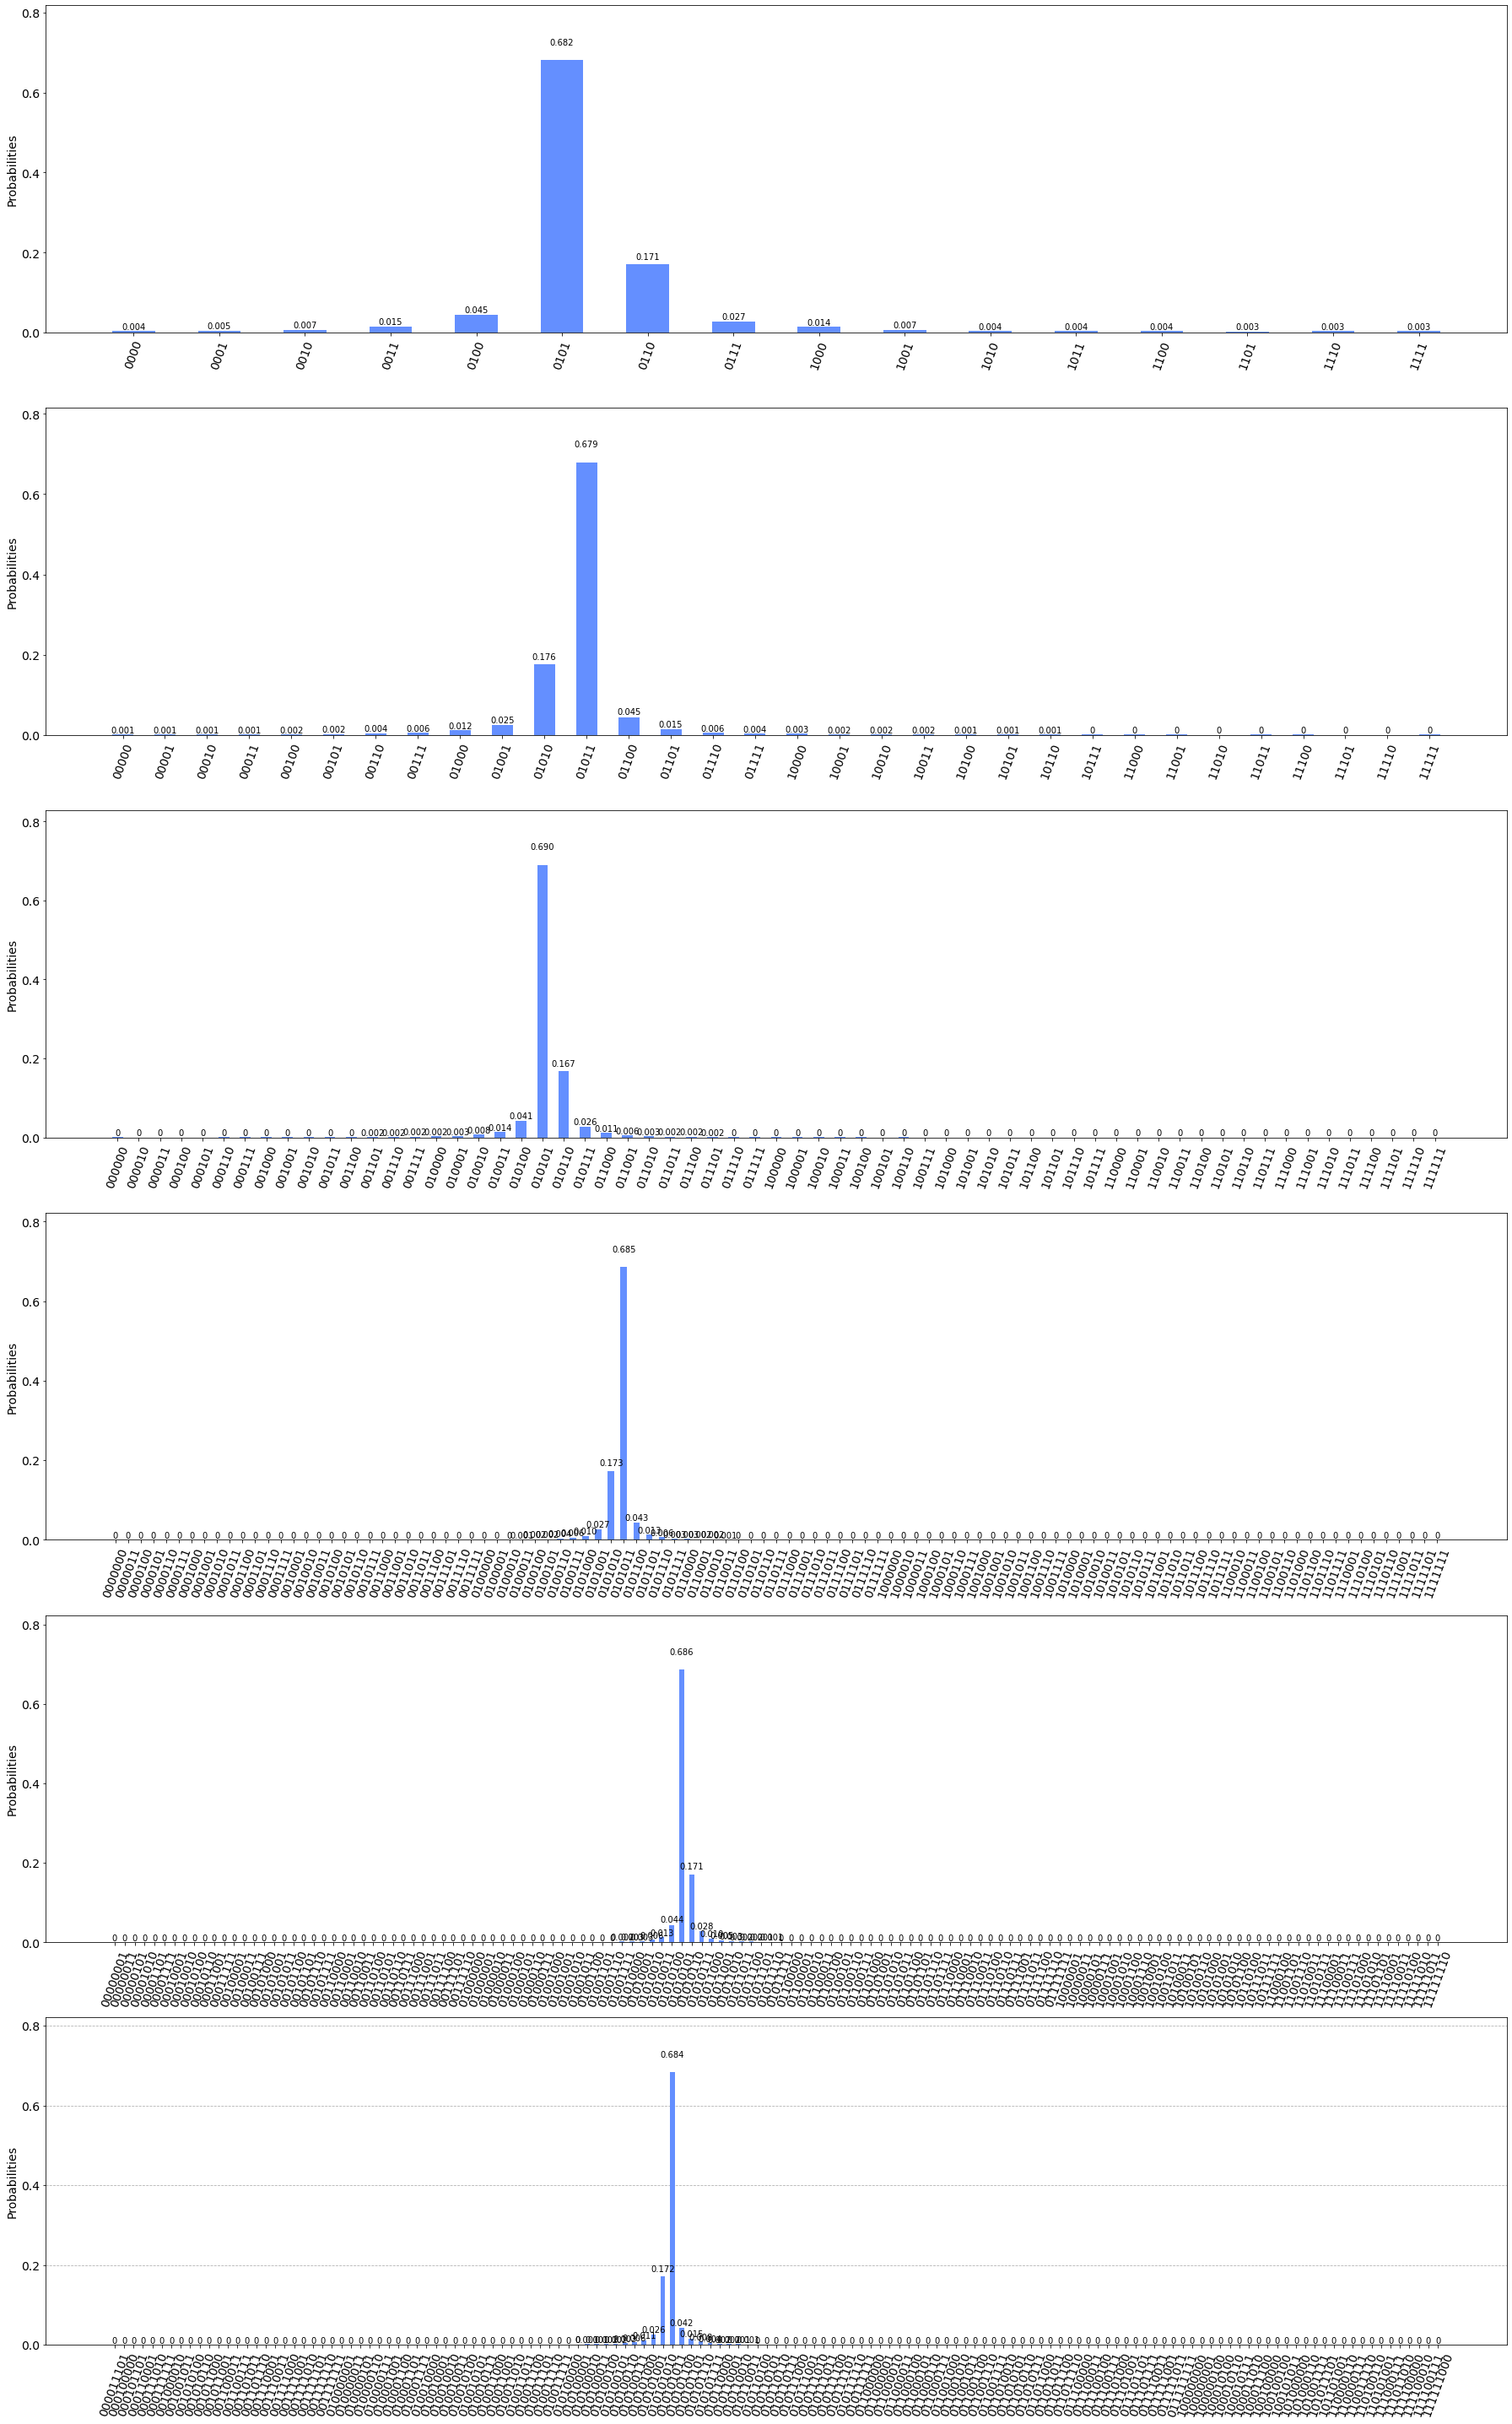

In [15]:
sim = Aer.get_backend('qasm_simulator')
shots = 20000
# Run this cell to simulate `circ` and plot the histograms of the results

results = execute(circ, sim, shots=shots).result()
n_circ = len(circ)
counts = [results.get_counts(idx) for idx in range(n_circ)]

fig, ax = plt.subplots(n_circ,1,figsize=(25,40))
for idx in range(n_circ):
    plot_histogram(counts[idx], ax=ax[idx])
plt.tight_layout()

`[QCQI]`より$t,n,e$には$e=2^{t-n}-1$の関係があるのでこれを確かめます。  
先ほどと同様にシミュレータの結果から$e$を求めて$e=2^{t-n}-1$と比較します。  
下の`get_result_stats`を実行します。  
あとで計算するために$n$も2から4まで変更して計算を行っておきます。

## get_result_info
- 入力：counts(tごとのシミュレータの計測結果したリスト), t_min(tの最小値), n_min(nの最小値), n_max(の最大値)
- 出力：data_e(tごとのeの値を格納下リスト), data_prob_sucess(tごとの成功確率を格納したリスト)

In [16]:
def get_result_info(counts, t_min, n_min, n_max, debug=False):
    data_e = []
    data_prob_sucess = []
    for n in range(n_min, n_max+1):
        data_e_tmp = []
        data_prob_sucess_tmp = []
        t = t_min
        ac = 2**(-n)
        for c in counts:
            max_binary, max_mes = max(c.items(), key=lambda x: x[1])
            b = int(max_binary, 2)/2**t
            if debug:
                print(t, max_binary, b)
            m_list = []
            for i in range(2**t):
                v = i/2**t
                if (b-ac < v < b+ac):
                    #print("\t", i, format(i, '0{}b'.format(t)), v)
                    m_list.append(i)
            # Estimate e
            e = 0
            while(True):
                count = 0
                for i in m_list:
                    m = i/2**t
                    if (abs(m-b) <= e/2**t):
                        count += 1
                    else:
                        break
                if (count == len(m_list)):
                    break
                e += 1
            data_e_tmp.append(e)
            # Prob Sucess
            sum_mes = 0
            for m in m_list:
                m_str = format(m, '0{}b'.format(t))
                if (m_str not in c.keys()):
                    continue
                sum_mes += c[m_str]
            data_prob_sucess_tmp.append(sum_mes/shots)
            t += 1
        data_e.append(data_e_tmp)
        data_prob_sucess.append(data_prob_sucess_tmp)
    return data_e, data_prob_sucess

In [17]:
data_e, data_prob_sucess = get_result_info(counts, 4, 2, 4)

## eの比較

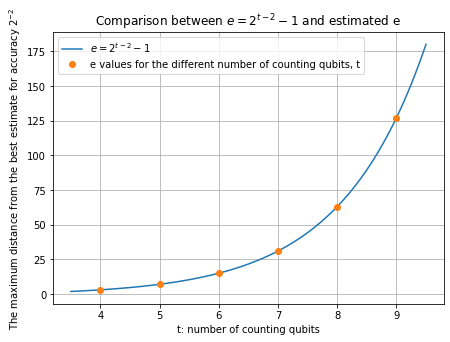

In [18]:
y_e = lambda t, n: 2**(t-n)-1
t_q = np.linspace(3.5, 9.5, 100 )
p_min = y_e(t_q, 2)

plt.figure(figsize=(7, 5))
plt.plot(t_q, p_min, label='$e=2^{t-2}-1$')
t_ = [i for i in range(4, 10)]
plt.plot(t_, data_e[0], 'o', label='e values for the different number of counting qubits, t')
plt.xlabel('t: number of counting qubits')
plt.ylabel('The maximum distance from the best estimate for accuracy $2^{-2}$')
plt.legend(loc='upper left')
plt.title('Comparison between $e=2^{t-2}-1$ and estimated e')
plt.grid()
plt.show()

$e=2^{t-2}-1$と計算結果が一致していることが分かります。

## 成功確率の比較

続いて成功確率をプロットしてみます。

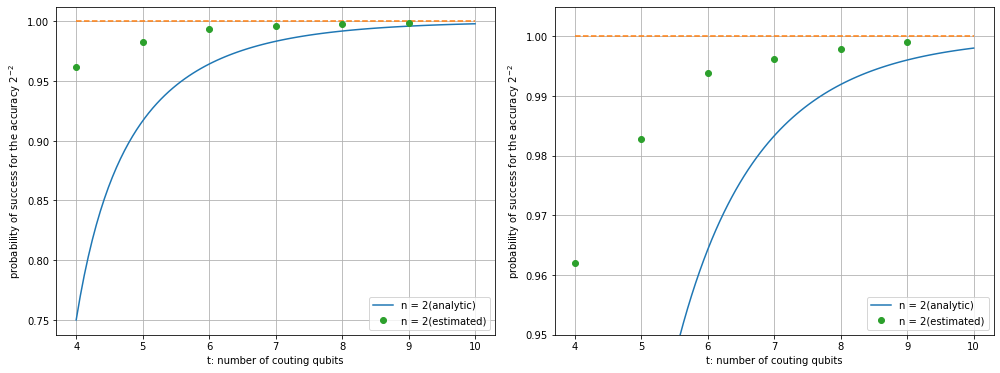

In [19]:
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
t_ = [i for i in range(4, 10)]
t_range = np.linspace(4, 10, 100)
prob_n2 = y_prob(t_range, 2)

# Ax1
ax1.plot(t_range, prob_n2, label="n = 2(analytic)")
ax1.plot(t_range, [1]*len(t_range), '--')
ax1.plot(t_, data_prob_sucess[0], 'o', label="n = 2(estimated)")

# Ax2
ax2.plot(t_range, prob_n2, label="n = 2(analytic)")
ax2.plot(t_range, [1]*len(t_range), '--')
ax2.plot(t_, data_prob_sucess[0], 'o', label="n = 2(estimated)")

# Legend
ax1.legend(loc = 'lower right')
ax2.legend(loc = 'lower right')
ax1.grid()
ax2.grid()
ax2.set_ylim(0.95, 1.005)
ax1.set_xlabel("t: number of couting qubits")
ax2.set_xlabel("t: number of couting qubits")
ax1.set_ylabel("probability of success for the accuracy $2^{-2}$")
ax2.set_ylabel("probability of success for the accuracy $2^{-2}$")
fig.tight_layout()
plt.show()

精度$2^{-n}$を変化させて結果をプロットしてみます。

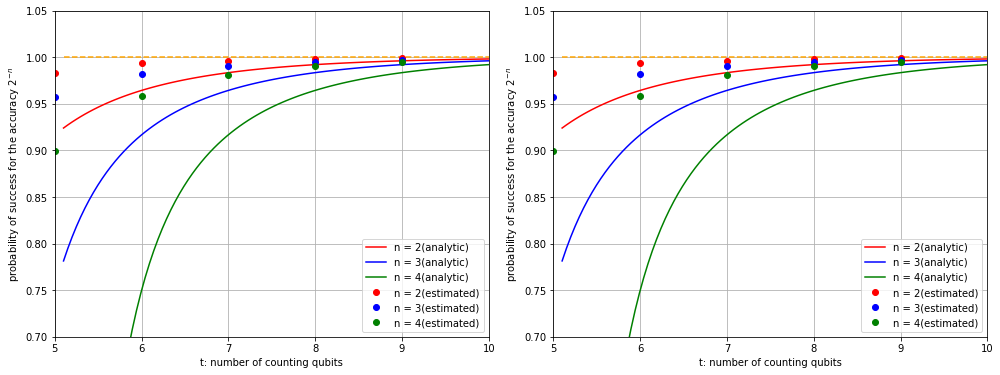

In [20]:
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
t_ = [i for i in range(4, 10)]
t_range = np.linspace(5.1, 10, 100)
prob_success_n = [y_prob(t_range, n) for n in [2, 3, 4]]
prob_n2, prob_n3, prob_n4  = prob_success_n[0], prob_success_n[1], prob_success_n[2]

# Ax1
## Analytic
ax1.plot(t_range, prob_n2, label="n = 2(analytic)", color="red")
ax1.plot(t_range, prob_n3, label="n = 3(analytic)", color="blue")
ax1.plot(t_range, prob_n4, label="n = 4(analytic)", color="green")
ax1.plot(t_range, [1]*len(t_range), '--', color="orange")
## Estimated
ax1.plot(t_, data_prob_sucess[0], 'o', label="n = 2(estimated)", color="red")
ax1.plot(t_, data_prob_sucess[1], 'o', label="n = 3(estimated)", color="blue")
ax1.plot(t_, data_prob_sucess[2], 'o', label="n = 4(estimated)", color="green")
# Legend
ax1.axis([5, 10, 0.7, 1.05])
ax1.set_xlabel('t: number of counting qubits')
ax1.set_ylabel('probability of success for the accuracy $2^{-n}$')
ax1.legend()
ax1.grid(True)


# Ax2
## Analytic
ax2.plot(t_range, prob_n2, label="n = 2(analytic)", color="red")
ax2.plot(t_range, prob_n3, label="n = 3(analytic)", color="blue")
ax2.plot(t_range, prob_n4, label="n = 4(analytic)", color="green")
ax2.plot(t_range, [1]*len(t_range), '--', color="orange")
## Estimated
ax2.plot(t_, data_prob_sucess[0], 'o', label="n = 2(estimated)", color="red")
ax2.plot(t_, data_prob_sucess[1], 'o', label="n = 3(estimated)", color="blue")
ax2.plot(t_, data_prob_sucess[2], 'o', label="n = 4(estimated)", color="green")
# Legend
ax2.set_ylim(0.9, 1.005)
ax2.axis([5, 10, 0.7, 1.05])
ax2.set_xlabel('t: number of counting qubits')
ax2.set_ylabel('probability of success for the accuracy $2^{-n}$')
ax2.legend()
ax2.grid(True)
fig.tight_layout()
plt.show()

以上のように計測用の量子ビット数$t$と要求精度$2^{-n}$の関係を確かめることが出来ました。